## Step 1: Import Libraries and Setup

In [1]:
# Core imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import warnings

# Project imports
from src.config import EvalConfig
from src.client import AzureLLMClient
from src.classifier import HairClassifier
from src.evaluator import Evaluator

# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Load environment variables
load_dotenv()

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Step 2: Load Configuration and Dataset

In [97]:
# Load configuration
cfg = EvalConfig("config/eval.yaml")

print("=" * 70)
print("CONFIGURATION LOADED")
print("=" * 70)
print(f"API Provider: {cfg.api['provider']}")
print(f"Model: {cfg.api['model']}")
print(f"Temperature: {cfg.api['temperature']}")
print(f"Timeout: {cfg.api['timeout']}s")
print(f"Retries: {cfg.api['retries']}")
print(f"\nDataset: {cfg.paths['dataset']}")
print(f"Prompt: {cfg.paths['prompt']}")
print("=" * 70)

CONFIGURATION LOADED
API Provider: azure_openai
Model: gpt-4o-mini
Temperature: 0
Timeout: 30s
Retries: 2

Dataset: data/annotations.csv
Prompt: prompts/vision_only_6.txt


## Step 3: Analyze Original Dataset

In [3]:
# Load original dataset
df_full = pd.read_csv(cfg.paths["dataset"])

print("=" * 70)
print("ORIGINAL DATASET ANALYSIS")
print("=" * 70)
print(f"Total Images: {len(df_full)}")
print(f"Number of Classes: {df_full['type'].nunique()}")
print(f"\nClass Distribution (Original):")
print("-" * 70)

class_dist_original = df_full['type'].value_counts().sort_index()
for hair_type, count in class_dist_original.items():
    percentage = (count / len(df_full)) * 100
    print(f"{hair_type}: {count:3d} images ({percentage:5.1f}%)")

print(f"\n{'Class Imbalance Statistics':^70}")
print("-" * 70)
print(f"Most Common Class: {class_dist_original.idxmax()} ({class_dist_original.max()} samples)")
print(f"Least Common Class: {class_dist_original.idxmin()} ({class_dist_original.min()} samples)")
print(f"Imbalance Ratio: {class_dist_original.max() / class_dist_original.min():.2f}:1")
print(f"Std Dev: {class_dist_original.std():.2f}")
print("=" * 70)

ORIGINAL DATASET ANALYSIS
Total Images: 266
Number of Classes: 12

Class Distribution (Original):
----------------------------------------------------------------------
1A:  25 images (  9.4%)
1B:  24 images (  9.0%)
1C:  24 images (  9.0%)
2A:  22 images (  8.3%)
2B:  24 images (  9.0%)
2C:  20 images (  7.5%)
3A:  23 images (  8.6%)
3B:  23 images (  8.6%)
3C:  20 images (  7.5%)
4A:  20 images (  7.5%)
4B:  20 images (  7.5%)
4C:  21 images (  7.9%)

                      Class Imbalance Statistics                      
----------------------------------------------------------------------
Most Common Class: 1A (25 samples)
Least Common Class: 2C (20 samples)
Imbalance Ratio: 1.25:1
Std Dev: 1.90


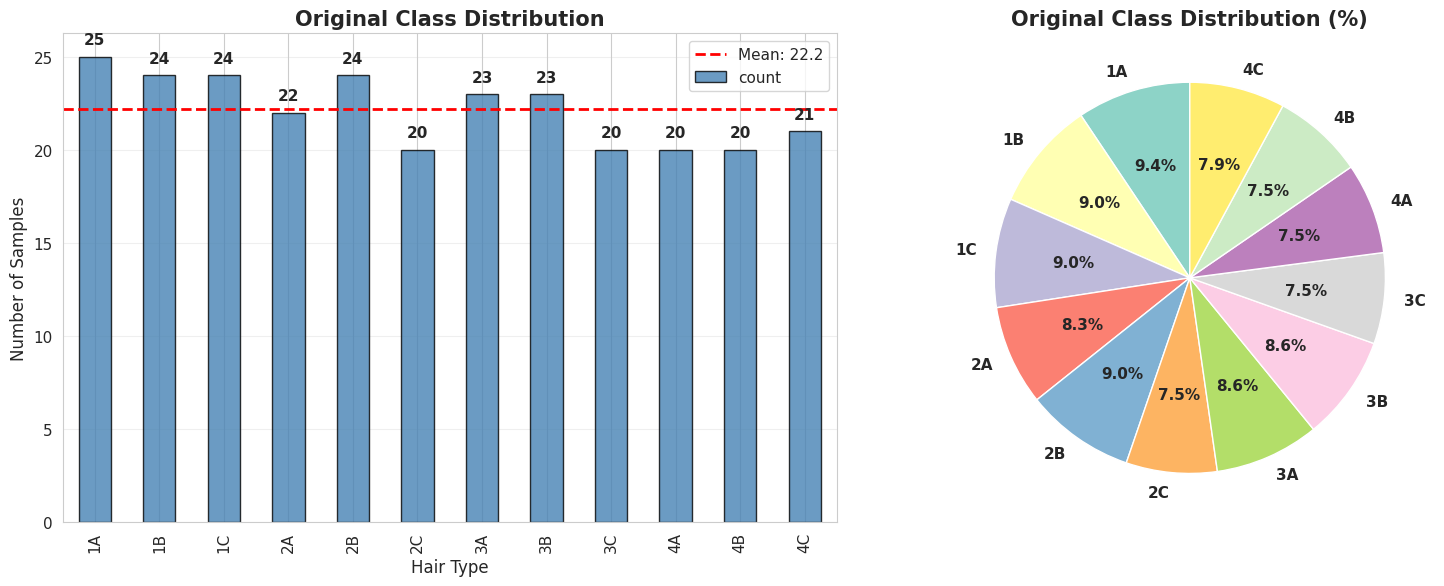

✓ Original dataset visualized


In [4]:
# Visualize original class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
class_dist_original.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black', alpha=0.8)
ax1.set_title('Original Class Distribution', fontsize=15, fontweight='bold')
ax1.set_xlabel('Hair Type', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.axhline(y=class_dist_original.mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {class_dist_original.mean():.1f}')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(class_dist_original):
    ax1.text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = sns.color_palette('Set3', len(class_dist_original))
ax2.pie(class_dist_original, labels=class_dist_original.index, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Original Class Distribution (%)', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Original dataset visualized")

## Step 4: Create Balanced Dataset (20 images per class)

To address class imbalance and ensure fair evaluation, we sample 20 images from each class.

In [5]:
# Create balanced dataset by sampling 20 images per class
SAMPLES_PER_CLASS = 20
np.random.seed(42)  # For reproducibility

df_balanced = df_full.groupby('type', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), SAMPLES_PER_CLASS), random_state=42)
).reset_index(drop=True)

# Save balanced dataset
balanced_dataset_path = "data/annotations_balanced.csv"
df_balanced.to_csv(balanced_dataset_path, index=False)

print("=" * 70)
print("BALANCED DATASET CREATED")
print("=" * 70)
print(f"Total Images: {len(df_balanced)}")
print(f"Samples per Class: {SAMPLES_PER_CLASS}")
print(f"Saved to: {balanced_dataset_path}")
print(f"\nClass Distribution (Balanced):")
print("-" * 70)

class_dist_balanced = df_balanced['type'].value_counts().sort_index()
for hair_type, count in class_dist_balanced.items():
    percentage = (count / len(df_balanced)) * 100
    print(f"{hair_type}: {count:3d} images ({percentage:5.1f}%)")

print("=" * 70)

BALANCED DATASET CREATED
Total Images: 240
Samples per Class: 20
Saved to: data/annotations_balanced.csv

Class Distribution (Balanced):
----------------------------------------------------------------------
1A:  20 images (  8.3%)
1B:  20 images (  8.3%)
1C:  20 images (  8.3%)
2A:  20 images (  8.3%)
2B:  20 images (  8.3%)
2C:  20 images (  8.3%)
3A:  20 images (  8.3%)
3B:  20 images (  8.3%)
3C:  20 images (  8.3%)
4A:  20 images (  8.3%)
4B:  20 images (  8.3%)
4C:  20 images (  8.3%)


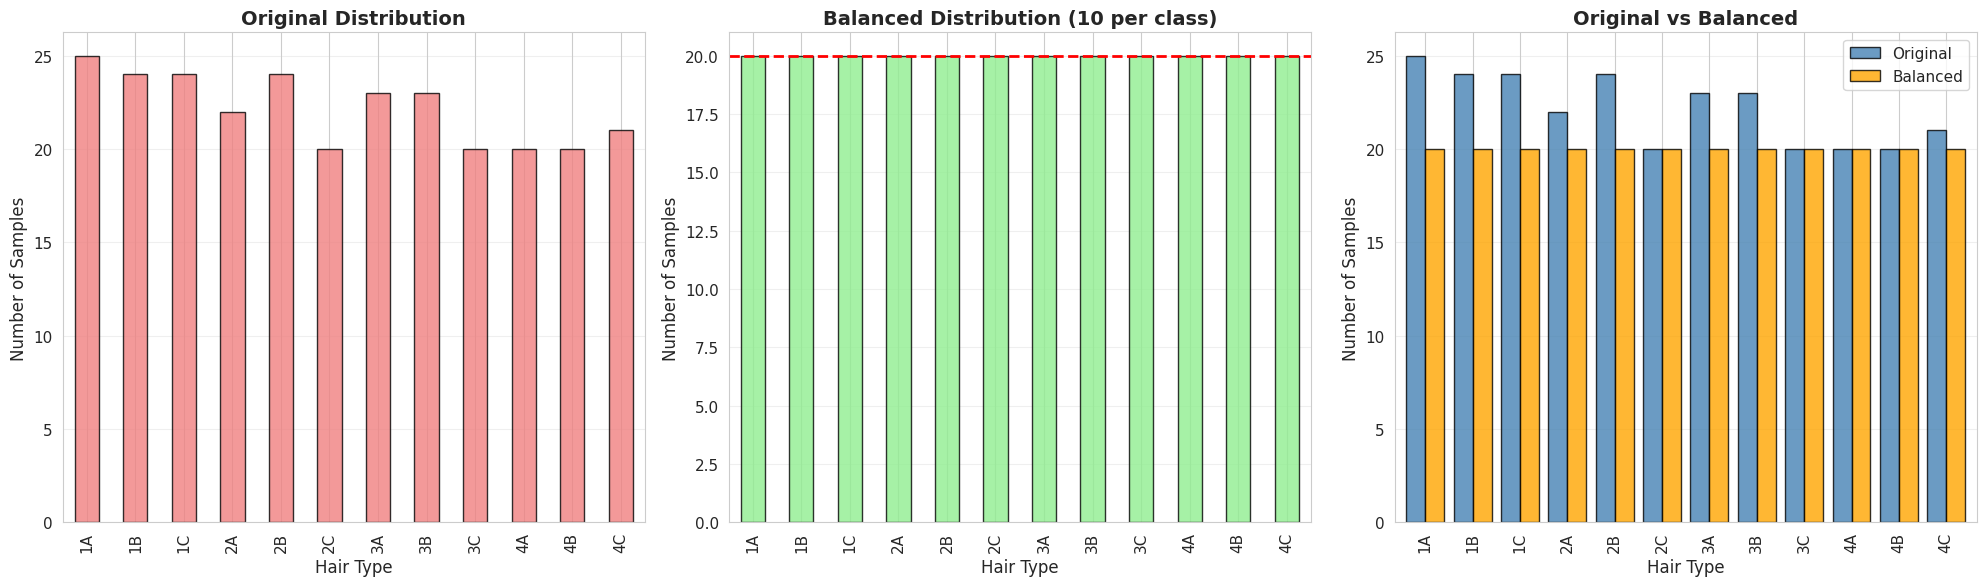

✓ Dataset comparison visualized


In [6]:
# Visualize balanced dataset
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Original distribution
class_dist_original.plot(kind='bar', ax=axes[0], color='lightcoral', edgecolor='black', alpha=0.8)
axes[0].set_title('Original Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hair Type', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Balanced distribution
class_dist_balanced.plot(kind='bar', ax=axes[1], color='lightgreen', edgecolor='black', alpha=0.8)
axes[1].set_title('Balanced Distribution (10 per class)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hair Type', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].axhline(y=SAMPLES_PER_CLASS, color='red', linestyle='--', linewidth=2)
axes[1].grid(axis='y', alpha=0.3)

# Comparison
comparison_df = pd.DataFrame({
    'Original': class_dist_original,
    'Balanced': class_dist_balanced
})
comparison_df.plot(kind='bar', ax=axes[2], color=['steelblue', 'orange'], 
                   edgecolor='black', alpha=0.8, width=0.8)
axes[2].set_title('Original vs Balanced', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Hair Type', fontsize=12)
axes[2].set_ylabel('Number of Samples', fontsize=12)
axes[2].legend(['Original', 'Balanced'], fontsize=11)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Dataset comparison visualized")

## Step 5: Initialize Classification System

In [98]:
# Load system prompt
with open(cfg.paths["prompt"], "r") as f:
    prompt = f.read()

print("=" * 70)
print("SYSTEM PROMPT")
print("=" * 70)
print(prompt)
print("=" * 70)

SYSTEM PROMPT
You are a professional hair texture and curl pattern classification system.

Context (STRICT):
- The input image is a segmented hair mask ONLY.
- Only the hair silhouette, contour, curvature, and internal geometry are visible.
- No color, strand-level texture, face, skin, scalp, or demographic cues are present.
- Absence of fine texture detail is EXPECTED and must not be treated as missing information.

Task:
Given the hair mask image, classify the hair into EXACTLY ONE of the following fine-grained hair types using ONLY visible geometric and morphological signals:

Straight
1A: straight and fine; elongated silhouette; minimal curvature or volume  
1B: straight with slight body; gentle bends; moderate expansion  
1C: straight-dominant but thick or stiff silhouette; irregular or bulky edges  

Wavy
2A: loose, elongated waves; weak curvature; mostly straight flow  
2B: repeated, visible S-shaped waves across the silhouette  
2C: strong, deep S-waves with high volume and cur

In [99]:
# Initialize API client
client = AzureLLMClient(
    api_key=os.getenv("AZUREOPENAI_API_KEY"),
    endpoint=os.getenv("AZUREOPENAI_API_ENDPOINT"),
    api_version=os.getenv("AZUREOPENAI_API_VERSION", "2024-02-15-preview")
)

# Initialize classifier and evaluator
classifier = HairClassifier(client, cfg, prompt)
evaluator = Evaluator(classifier)

print("✓ Classification system initialized")
print(f"  - API: {cfg.api['provider']}")
print(f"  - Model: {cfg.api['model']}")
print(f"  - Ready for evaluation")

✓ Classification system initialized
  - API: azure_openai
  - Model: gpt-4o-mini
  - Ready for evaluation


## Step 6: Run Evaluation on Balanced Dataset

In [130]:
# Run evaluation on balanced dataset
print("=" * 70)
print("STARTING EVALUATION")
print("=" * 70)
print(f"Dataset: {balanced_dataset_path}")
print(f"Total samples: {len(df_balanced)}")
print(f"Expected duration: ~{len(df_balanced) * 2 / 60:.1f} minutes")
print("\nProcessing...\n")

results = evaluator.run(
    dataset_path=balanced_dataset_path,
    max_samples=100,  # Use all samples from balanced dataset
    verbose=True,
    save_results=True
)

print(f"\n{'=' * 70}")
print("EVALUATION COMPLETE")
print(f"{'=' * 70}")
print(f"Results saved to: results_evaluation_*.csv")

STARTING EVALUATION
Dataset: data/annotations_balanced.csv
Total samples: 240
Expected duration: ~8.0 minutes

Processing...



Evaluating hair classification: 100%|█| 100/100 [52:03<00:00, 31.24s/it, last_pr



✓ Results saved to: results_evaluation_20260210_150148.csv

EVALUATION COMPLETE
Results saved to: results_evaluation_*.csv


## Step 6.5: Hierarchical Top-3 Accuracy Evaluation

### Understanding Hair Type Visual Hierarchy
The Andre Walker system organizes hair into visually similar families. Misclassifications between neighbor types (e.g., 2A↔2B) are less critical than cross-family errors (e.g., 1A↔4C).

In [131]:
# Define neighbor groups based on visual similarity
NEIGHBORS = {
    "1A": ["1A", "1B"],
    "1B": ["1A", "1B", "1C"], 
    "1C": ["1B", "1C", "2A"],
    "2A": ["1C", "2A", "2B"],
    "2B": ["2A", "2B", "2C"],
    "2C": ["2B", "2C", "3A"],
    "3A": ["2C", "3A", "3B"],
    "3B": ["3A", "3B", "3C"],
    "3C": ["3B", "3C", "4A"],
    "4A": ["3C", "4A", "4B"],
    "4B": ["4A", "4B", "4C"],
    "4C": ["4B", "4C"]
}

def hierarchical_top3_accuracy(y_true, y_pred):
    """
    Calculate accuracy considering visually similar neighbor classes.
    
    Args:
        y_true: List of true labels
        y_pred: List of predicted labels
        
    Returns:
        float: Hierarchical top-3 accuracy score
        list: Match details for each prediction
    """
    correct = 0
    neighbor_matches = []
    
    for true_label, pred_label in zip(y_true, y_pred):
        if pred_label in NEIGHBORS and true_label in NEIGHBORS[pred_label]:
            correct += 1
            neighbor_matches.append({
                'true': true_label,
                'pred': pred_label,
                'match_type': 'exact' if true_label == pred_label else 'neighbor'
            })
    
    return correct / len(y_true), neighbor_matches

# Load prediction results from evaluation
results_files = [f for f in os.listdir('.') if f.startswith('results_evaluation_') and f.endswith('.csv')]
results_files.sort(reverse=True)  # Get most recent
results_df = pd.read_csv(results_files[0])

y_true = results_df['type'].tolist()
y_pred = results_df['predicted_label'].tolist()

# Calculate hierarchical top-3 accuracy
htop3_acc, neighbor_matches = hierarchical_top3_accuracy(y_true, y_pred)

# Analyze match types
exact_matches = sum(1 for m in neighbor_matches if m['match_type'] == 'exact')
neighbor_only = sum(1 for m in neighbor_matches if m['match_type'] == 'neighbor')

print("=" * 70)
print("HIERARCHICAL TOP-3 ACCURACY ANALYSIS")
print("=" * 70)
print(f"\n{'Performance Comparison':^70}")
print("-" * 70)
print(f"Top-1 Accuracy (Exact):      {results['accuracy']*100:>6.2f}%")
print(f"Hierarchical Top-3:          {htop3_acc*100:>6.2f}%")
print(f"Improvement:                 +{(htop3_acc - results['accuracy'])*100:>5.2f}pp")

print(f"\n{'Match Type Breakdown':^70}")
print("-" * 70)
print(f"Exact Matches:               {exact_matches:>6d} ({exact_matches/len(y_true)*100:>5.1f}%)")
print(f"Neighbor Matches:            {neighbor_only:>6d} ({neighbor_only/len(y_true)*100:>5.1f}%)")
print(f"Outside Neighbor Group:      {len(y_true) - len(neighbor_matches):>6d} ({(1-htop3_acc)*100:>5.1f}%)")
print(f"Total Samples:               {len(y_true):>6d}")

print(f"\n{'Practical Interpretation':^70}")
print("-" * 70)
print(f"{htop3_acc*100:.1f}% of predictions correctly identify:")
print(f"  • The exact hair type, OR")
print(f"  • A visually-similar neighbor type")
print(f"\nThis means {htop3_acc*100:.1f}% of recommendations are serviceable,")
print(f"as neighboring types have similar care requirements.")

print("=" * 70)

HIERARCHICAL TOP-3 ACCURACY ANALYSIS

                        Performance Comparison                        
----------------------------------------------------------------------
Top-1 Accuracy (Exact):       33.00%
Hierarchical Top-3:           82.00%
Improvement:                 +49.00pp

                         Match Type Breakdown                         
----------------------------------------------------------------------
Exact Matches:                   33 ( 33.0%)
Neighbor Matches:                49 ( 49.0%)
Outside Neighbor Group:          18 ( 18.0%)
Total Samples:                  100

                       Practical Interpretation                       
----------------------------------------------------------------------
82.0% of predictions correctly identify:
  • The exact hair type, OR
  • A visually-similar neighbor type

This means 82.0% of recommendations are serviceable,
as neighboring types have similar care requirements.


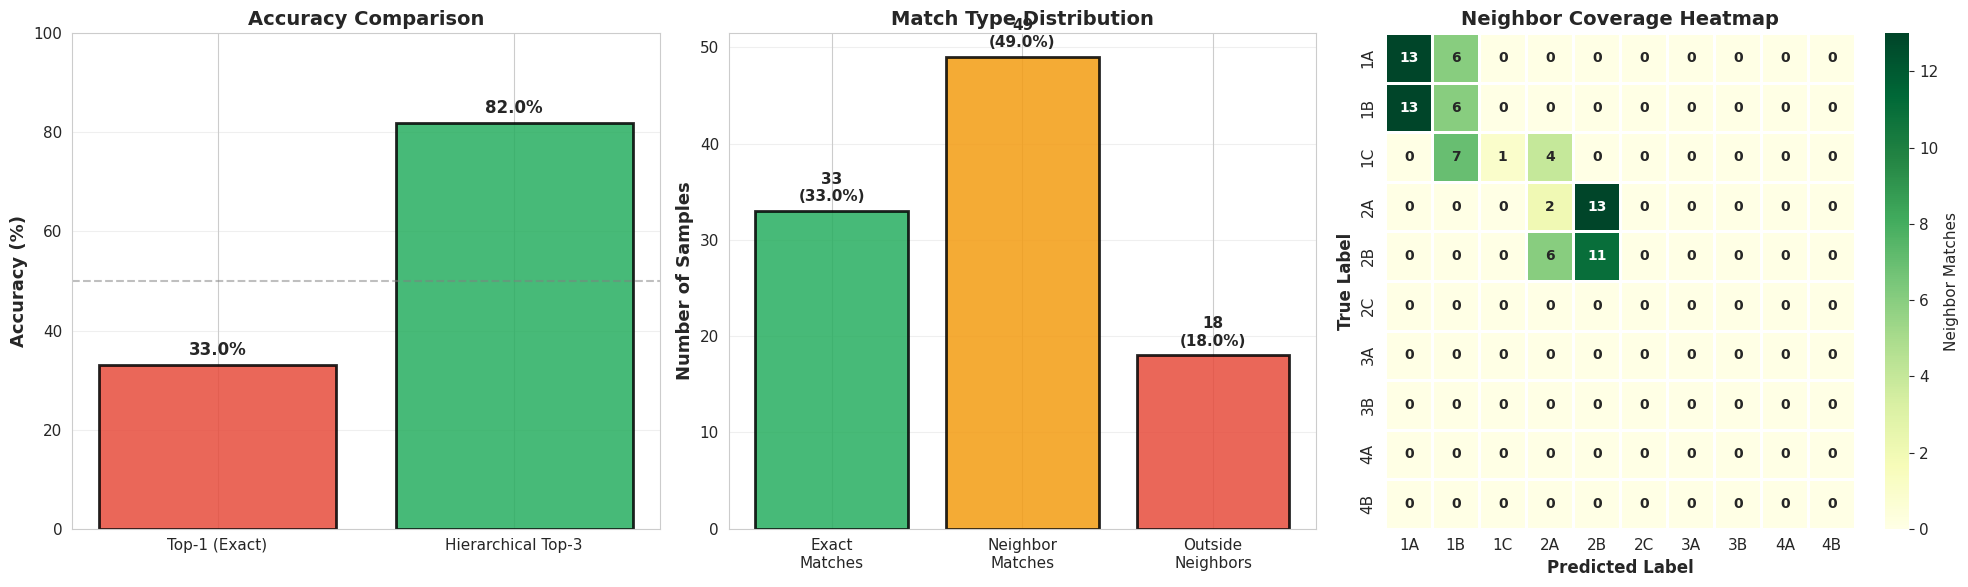

✓ Hierarchical accuracy analysis visualized

Key Insights:
• 82.0% of predictions are within acceptable visual range
• 49 predictions salvaged by neighbor tolerance
• Only 18.0% are cross-family errors needing improvement


In [132]:
# Visualize hierarchical accuracy improvement
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Accuracy comparison
metrics_comparison = {
    'Top-1 (Exact)': results['accuracy'] * 100,
    'Hierarchical Top-3': htop3_acc * 100
}
colors_acc = ['#E74C3C', '#27AE60']
axes[0].bar(metrics_comparison.keys(), metrics_comparison.values(), 
            color=colors_acc, edgecolor='black', linewidth=2, alpha=0.85)
axes[0].set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 100)
axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(axis='y', alpha=0.3)
for i, (label, val) in enumerate(metrics_comparison.items()):
    axes[0].text(i, val + 2, f'{val:.1f}%', ha='center', 
                 fontweight='bold', fontsize=12)

# Match type breakdown
match_types = ['Exact\nMatches', 'Neighbor\nMatches', 'Outside\nNeighbors']
match_counts = [exact_matches, neighbor_only, len(y_true) - len(neighbor_matches)]
match_colors = ['#27AE60', '#F39C12', '#E74C3C']
axes[1].bar(match_types, match_counts, color=match_colors, 
            edgecolor='black', linewidth=2, alpha=0.85)
axes[1].set_ylabel('Number of Samples', fontsize=13, fontweight='bold')
axes[1].set_title('Match Type Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(match_counts):
    pct = (v / len(y_true)) * 100
    axes[1].text(i, v + 1, f'{v}\n({pct:.1f}%)', ha='center', 
                 fontweight='bold', fontsize=11)

# ------------------------------------------------------------------
# Build a SAFE, COMPLETE label space
# ------------------------------------------------------------------
labels = sorted(
    set(l.upper() for l in results_df['type'].unique())
    | set(l.upper() for l in y_pred)
)

# Optional but recommended: exclude Unknown from heatmap
labels = [l for l in labels if l != "UNKNOWN"]

label_to_idx = {label: i for i, label in enumerate(labels)}

neighbor_coverage = np.zeros((len(labels), len(labels)))

# ------------------------------------------------------------------
# Populate neighbor coverage matrix (DEFENSIVE)
# ------------------------------------------------------------------
for true_label, pred_label in zip(y_true, y_pred):

    true_label = true_label.upper()
    pred_label = pred_label.upper()

    if true_label == "UNKNOWN" or pred_label == "UNKNOWN":
        continue

    if pred_label not in NEIGHBORS:
        continue

    if true_label not in NEIGHBORS[pred_label]:
        continue

    if true_label not in label_to_idx or pred_label not in label_to_idx:
        continue

    true_idx = label_to_idx[true_label]
    pred_idx = label_to_idx[pred_label]
    neighbor_coverage[true_idx, pred_idx] += 1

# ------------------------------------------------------------------
# Heatmap
# ------------------------------------------------------------------
sns.heatmap(
    neighbor_coverage,
    annot=True,
    fmt='.0f',
    cmap='YlGn',
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[2],
    cbar_kws={'label': 'Neighbor Matches'},
    linewidths=1,
    linecolor='white',
    annot_kws={'fontsize': 10, 'fontweight': 'bold'}
)

axes[2].set_title('Neighbor Coverage Heatmap', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()

print("✓ Hierarchical accuracy analysis visualized")
print("\nKey Insights:")
print(f"• {htop3_acc*100:.1f}% of predictions are within acceptable visual range")
print(f"• {neighbor_only} predictions salvaged by neighbor tolerance")
print(f"• Only {(1-htop3_acc)*100:.1f}% are cross-family errors needing improvement")

In [133]:
# Ensure required variables exist
class_report = results["classification_report"]
labels = results["labels"]

# Analyze neighbor errors in detail
print("=" * 85)
print("NEIGHBOR ERROR ANALYSIS")
print("=" * 85)

class_htop3 = {}
for true_class in labels:
    class_samples = [(t, p) for t, p in zip(y_true, y_pred) if t == true_class]
    if len(class_samples) > 0:
        class_correct = sum(
            1 for t, p in class_samples if t in NEIGHBORS.get(p, [])
        )
        class_htop3[true_class] = class_correct / len(class_samples)
    else:
        class_htop3[true_class] = 0.0

df_htop3 = pd.DataFrame({
    'Hair Type': labels,
    'Top-1 Accuracy': [class_report.get(l, {}).get('recall', 0) for l in labels],
    'Hierarchical Top-3': [class_htop3[l] for l in labels],
    'Improvement': [
        class_htop3[l] - class_report.get(l, {}).get('recall', 0)
        for l in labels
    ]
})

print("\nPer-Class Hierarchical Performance:")
print("-" * 85)
print(df_htop3.to_string(index=False))

print(f"\n{'Classes with Largest Improvement':^85}")
print("-" * 85)
top_improved = df_htop3.nlargest(5, 'Improvement')
for _, row in top_improved.iterrows():
    print(f"{row['Hair Type']}: {row['Top-1 Accuracy']:.3f} → {row['Hierarchical Top-3']:.3f} "
          f"(+{row['Improvement']*100:.1f}pp)")

print(f"\n{'Cross-Family Errors (Critical Issues)':^85}")
print("-" * 85)
cross_family_errors = []
for true_label, pred_label in zip(y_true, y_pred):
    if pred_label not in NEIGHBORS or true_label not in NEIGHBORS[pred_label]:
        cross_family_errors.append((true_label, pred_label))

if len(cross_family_errors) > 0:
    cross_family_counts = pd.Series(cross_family_errors).value_counts().head(10)
    for (true_l, pred_l), count in cross_family_counts.items():
        print(f"{true_l} → {pred_l}: {count} occurrences")
else:
    print("No cross-family errors found!")

print("=" * 85)

NEIGHBOR ERROR ANALYSIS

Per-Class Hierarchical Performance:
-------------------------------------------------------------------------------------
Hair Type  Top-1 Accuracy  Hierarchical Top-3  Improvement
       1A            0.65                0.95         0.30
       1B            0.30                0.95         0.65
       1C            0.05                0.60         0.55
       2A            0.10                0.75         0.65
       2B            0.55                0.85         0.30

                          Classes with Largest Improvement                           
-------------------------------------------------------------------------------------
2A: 0.100 → 0.750 (+65.0pp)
1B: 0.300 → 0.950 (+65.0pp)
1C: 0.050 → 0.600 (+55.0pp)
1A: 0.650 → 0.950 (+30.0pp)
2B: 0.550 → 0.850 (+30.0pp)

                        Cross-Family Errors (Critical Issues)                        
-------------------------------------------------------------------------------------
2A → 1B: 4 oc

## Step 7: Overall Performance Metrics

In [134]:
# Display overall metrics
print("=" * 70)
print("OVERALL PERFORMANCE METRICS")
print("=" * 70)
print(f"\n{'Classification Accuracy':^70}")
print("-" * 70)
print(f"Top-1 Accuracy (Exact):      {results['accuracy']*100:>6.2f}%")
print(f"Hierarchical Top-3:          {htop3_acc*100:>6.2f}%")
print(f"Improvement:                 +{(htop3_acc - results['accuracy'])*100:>5.2f}pp")
print(f"\nWeighted F1-Score:           {results['weighted_f1']:>6.4f}")
print(f"Macro F1-Score:              {results['macro_f1']:>6.4f}")
print(f"Weighted Precision:          {results['weighted_precision']:>6.4f}")
print(f"Weighted Recall:             {results['weighted_recall']:>6.4f}")

print(f"\n{'Prediction Summary':^70}")
print("-" * 70)
print(f"Total Samples:               {results['n_samples']:>6d}")
print(f"Exact Matches:               {exact_matches:>6d} ({exact_matches/len(y_true)*100:>5.1f}%)")
print(f"Neighbor Matches:            {neighbor_only:>6d} ({neighbor_only/len(y_true)*100:>5.1f}%)")
print(f"Outside Neighbor Group:      {len(y_true) - len(neighbor_matches):>6d} ({(1-htop3_acc)*100:>5.1f}%)")
print(f"Error Rate (Exact):          {results['n_errors']/results['n_samples']*100:>6.2f}%")
print(f"Error Rate (Hierarchical):   {(1-htop3_acc)*100:>6.2f}%")

print("=" * 70)

OVERALL PERFORMANCE METRICS

                       Classification Accuracy                        
----------------------------------------------------------------------
Top-1 Accuracy (Exact):       33.00%
Hierarchical Top-3:           82.00%
Improvement:                 +49.00pp

Weighted F1-Score:           0.3000
Macro F1-Score:              0.3000
Weighted Precision:          0.3264
Weighted Recall:             0.3300

                          Prediction Summary                          
----------------------------------------------------------------------
Total Samples:                  100
Exact Matches:                   33 ( 33.0%)
Neighbor Matches:                49 ( 49.0%)
Outside Neighbor Group:          18 ( 18.0%)
Error Rate (Exact):           67.00%
Error Rate (Hierarchical):    18.00%


## Step 8: Confusion Matrix Analysis

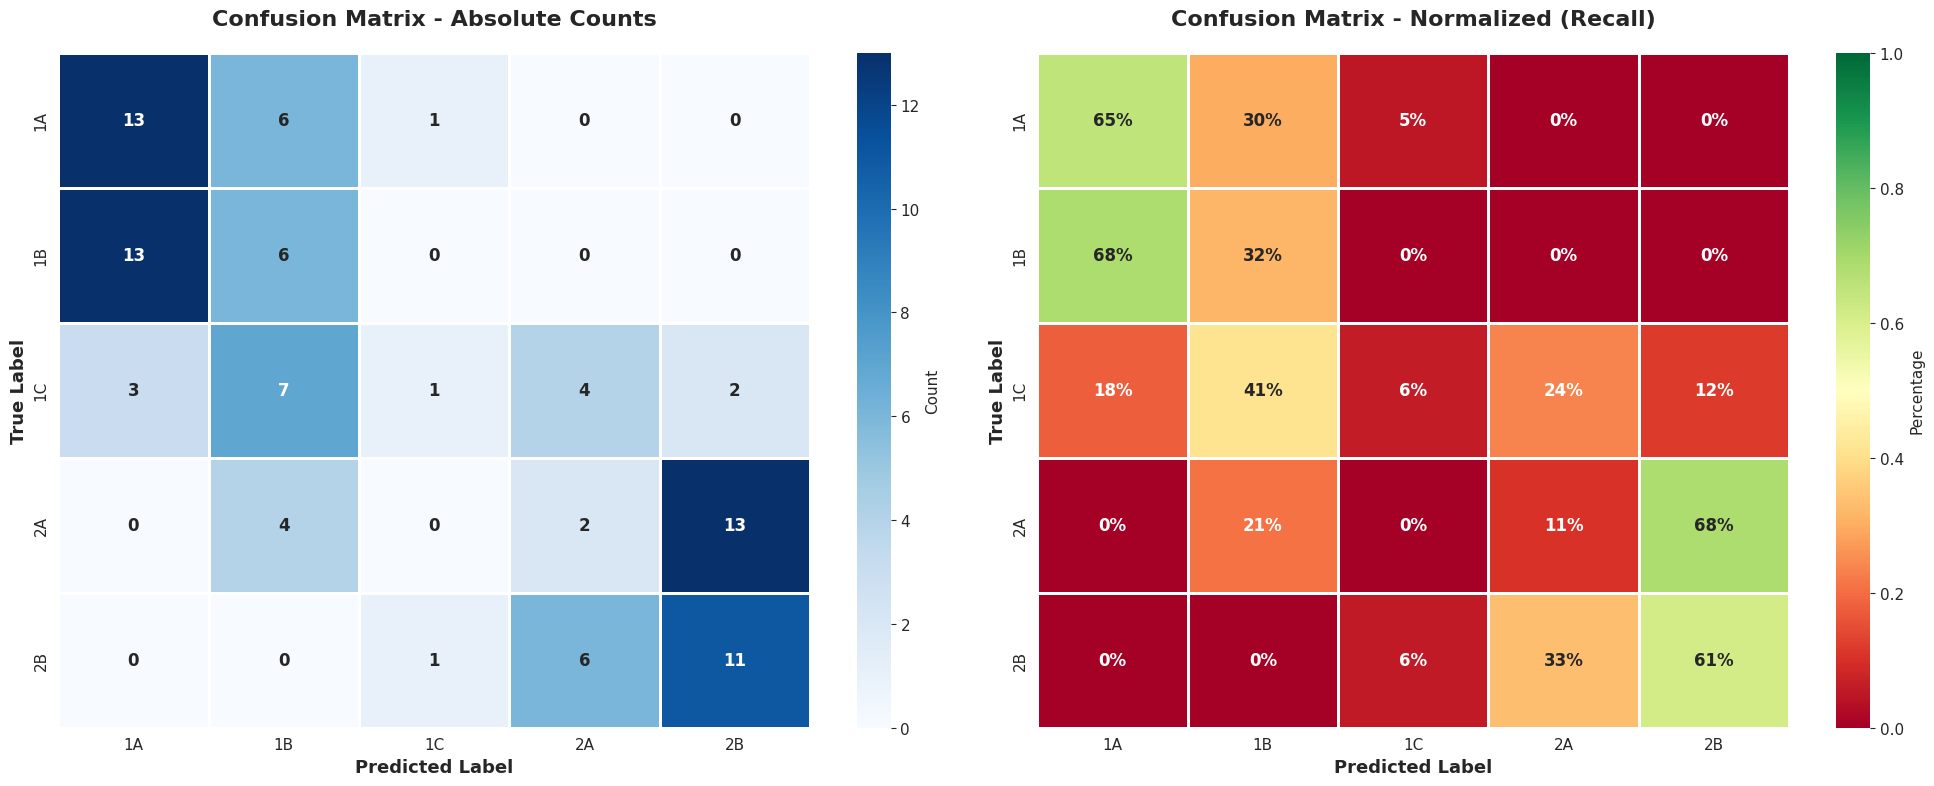

✓ Confusion matrices displayed

Interpretation:
- Diagonal values (dark blue/green): Correct predictions
- Off-diagonal values: Misclassifications
- Normalized matrix shows percentage correctly classified per true class


In [135]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

cm = results["confusion_matrix"]
labels = results["labels"]

# Absolute counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, 
            ax=axes[0], cbar_kws={'label': 'Count'}, linewidths=1, linecolor='white',
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Confusion Matrix - Absolute Counts', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=13, fontweight='bold')
axes[0].tick_params(labelsize=11)

# Normalized by row (recall perspective)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

sns.heatmap(cm_normalized, annot=True, fmt='.0%', cmap='RdYlGn', xticklabels=labels, 
            yticklabels=labels, ax=axes[1], cbar_kws={'label': 'Percentage'}, 
            linewidths=1, linecolor='white', annot_kws={'fontsize': 12, 'fontweight': 'bold'},
            vmin=0, vmax=1)
axes[1].set_title('Confusion Matrix - Normalized (Recall)', fontsize=16, fontweight='bold', pad=20)
axes[1].set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=13, fontweight='bold')
axes[1].tick_params(labelsize=11)

plt.tight_layout()
plt.show()

print("✓ Confusion matrices displayed")
print("\nInterpretation:")
print("- Diagonal values (dark blue/green): Correct predictions")
print("- Off-diagonal values: Misclassifications")
print("- Normalized matrix shows percentage correctly classified per true class")

## Step 9: Per-Class Performance Metrics

In [136]:
# Extract per-class metrics
class_report = results["classification_report"]
class_metrics = []

for label in labels:
    if label in class_report:
        class_metrics.append({
            'Hair Type': label,
            'Precision': class_report[label]['precision'],
            'Recall': class_report[label]['recall'],
            'F1-Score': class_report[label]['f1-score'],
            'Support': int(class_report[label]['support'])
        })

df_metrics = pd.DataFrame(class_metrics)

print("=" * 85)
print("PER-CLASS PERFORMANCE METRICS")
print("=" * 85)
print(df_metrics.to_string(index=False))
print("=" * 85)

# Summary statistics
print(f"\nSummary Statistics:")
print(f"  Average Precision: {df_metrics['Precision'].mean():.4f}")
print(f"  Average Recall:    {df_metrics['Recall'].mean():.4f}")
print(f"  Average F1-Score:  {df_metrics['F1-Score'].mean():.4f}")

PER-CLASS PERFORMANCE METRICS
Hair Type  Precision  Recall  F1-Score  Support
       1A   0.448276    0.65  0.530612       20
       1B   0.260870    0.30  0.279070       20
       1C   0.333333    0.05  0.086957       20
       2A   0.166667    0.10  0.125000       20
       2B   0.423077    0.55  0.478261       20

Summary Statistics:
  Average Precision: 0.3264
  Average Recall:    0.3300
  Average F1-Score:  0.3000


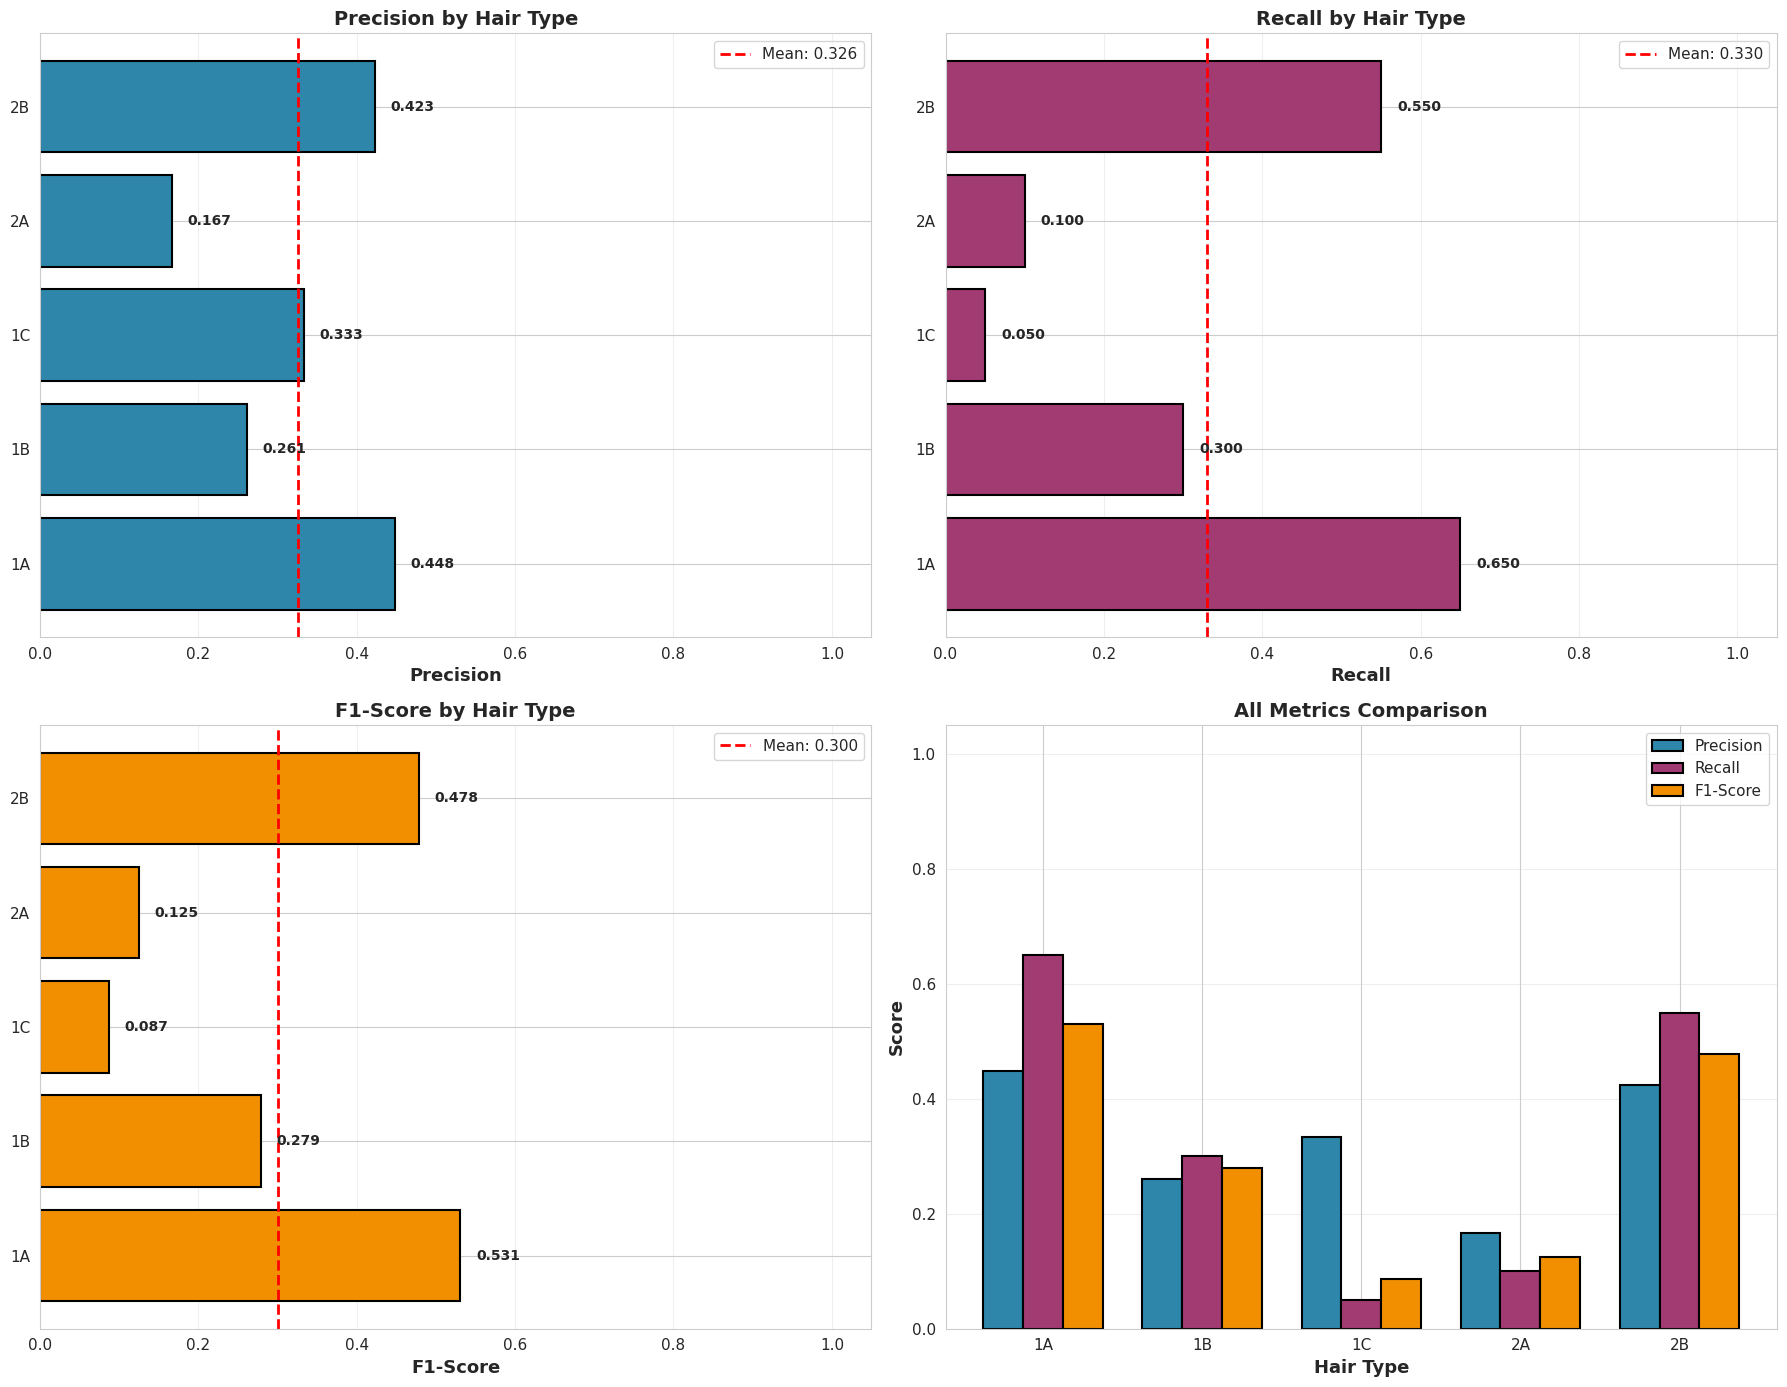

✓ Per-class metrics visualized


In [137]:
# Visualize per-class metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Precision
axes[0, 0].barh(df_metrics['Hair Type'], df_metrics['Precision'], 
                color='#2E86AB', edgecolor='black', linewidth=1.5)
axes[0, 0].set_xlabel('Precision', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Precision by Hair Type', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 1.05)
axes[0, 0].axvline(x=df_metrics['Precision'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f"Mean: {df_metrics['Precision'].mean():.3f}")
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].legend()
for i, v in enumerate(df_metrics['Precision']):
    axes[0, 0].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=10)

# Recall
axes[0, 1].barh(df_metrics['Hair Type'], df_metrics['Recall'], 
                color='#A23B72', edgecolor='black', linewidth=1.5)
axes[0, 1].set_xlabel('Recall', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Recall by Hair Type', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim(0, 1.05)
axes[0, 1].axvline(x=df_metrics['Recall'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f"Mean: {df_metrics['Recall'].mean():.3f}")
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].legend()
for i, v in enumerate(df_metrics['Recall']):
    axes[0, 1].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=10)

# F1-Score
axes[1, 0].barh(df_metrics['Hair Type'], df_metrics['F1-Score'], 
                color='#F18F01', edgecolor='black', linewidth=1.5)
axes[1, 0].set_xlabel('F1-Score', fontsize=13, fontweight='bold')
axes[1, 0].set_title('F1-Score by Hair Type', fontsize=14, fontweight='bold')
axes[1, 0].set_xlim(0, 1.05)
axes[1, 0].axvline(x=df_metrics['F1-Score'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f"Mean: {df_metrics['F1-Score'].mean():.3f}")
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].legend()
for i, v in enumerate(df_metrics['F1-Score']):
    axes[1, 0].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold', fontsize=10)

# All metrics comparison
x = np.arange(len(df_metrics))
width = 0.25
axes[1, 1].bar(x - width, df_metrics['Precision'], width, label='Precision', 
               color='#2E86AB', edgecolor='black', linewidth=1.5)
axes[1, 1].bar(x, df_metrics['Recall'], width, label='Recall', 
               color='#A23B72', edgecolor='black', linewidth=1.5)
axes[1, 1].bar(x + width, df_metrics['F1-Score'], width, label='F1-Score', 
               color='#F18F01', edgecolor='black', linewidth=1.5)
axes[1, 1].set_xlabel('Hair Type', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Score', fontsize=13, fontweight='bold')
axes[1, 1].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(df_metrics['Hair Type'])
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

print("✓ Per-class metrics visualized")

## Step 10: Latency Analysis

In [138]:
# Display latency statistics
latency_stats = results["latency_stats"]

print("=" * 70)
print("LATENCY STATISTICS (Single-Image Requests)")
print("=" * 70)
print(f"\n{'Basic Statistics':^70}")
print("-" * 70)
print(f"Mean:                {latency_stats['mean']:>10.3f}s")
print(f"Median:              {latency_stats['median']:>10.3f}s")
print(f"Std Dev:             {latency_stats['std']:>10.3f}s")
print(f"Min:                 {latency_stats['min']:>10.3f}s")
print(f"Max:                 {latency_stats['max']:>10.3f}s")

print(f"\n{'Percentiles':^70}")
print("-" * 70)
print(f"P25 (25th):          {latency_stats['p25']:>10.3f}s")
print(f"P50 (Median):        {latency_stats['median']:>10.3f}s")
print(f"P75 (75th):          {latency_stats['p75']:>10.3f}s")
print(f"P95 (95th):          {latency_stats['p95']:>10.3f}s")
print(f"P99 (99th):          {latency_stats['p99']:>10.3f}s")

print(f"\n{'Throughput (Sequential)':^70}")
print("-" * 70)
throughput = 1 / latency_stats['mean'] if latency_stats['mean'] > 0 else 0
print(f"Requests/Second:     {throughput:>10.2f} req/s")
print(f"Requests/Minute:     {throughput * 60:>10.2f} req/min")
print(f"Time for 1000 imgs:  {(1000 / throughput) / 60:>10.2f} minutes")

print("=" * 70)

LATENCY STATISTICS (Single-Image Requests)

                           Basic Statistics                           
----------------------------------------------------------------------
Mean:                    31.214s
Median:                   4.124s
Std Dev:                 29.737s
Min:                      1.312s
Max:                     84.272s

                             Percentiles                              
----------------------------------------------------------------------
P25 (25th):               1.901s
P50 (Median):             4.124s
P75 (75th):              60.513s
P95 (95th):              62.637s
P99 (99th):              72.057s

                       Throughput (Sequential)                        
----------------------------------------------------------------------
Requests/Second:           0.03 req/s
Requests/Minute:           1.92 req/min
Time for 1000 imgs:      520.23 minutes


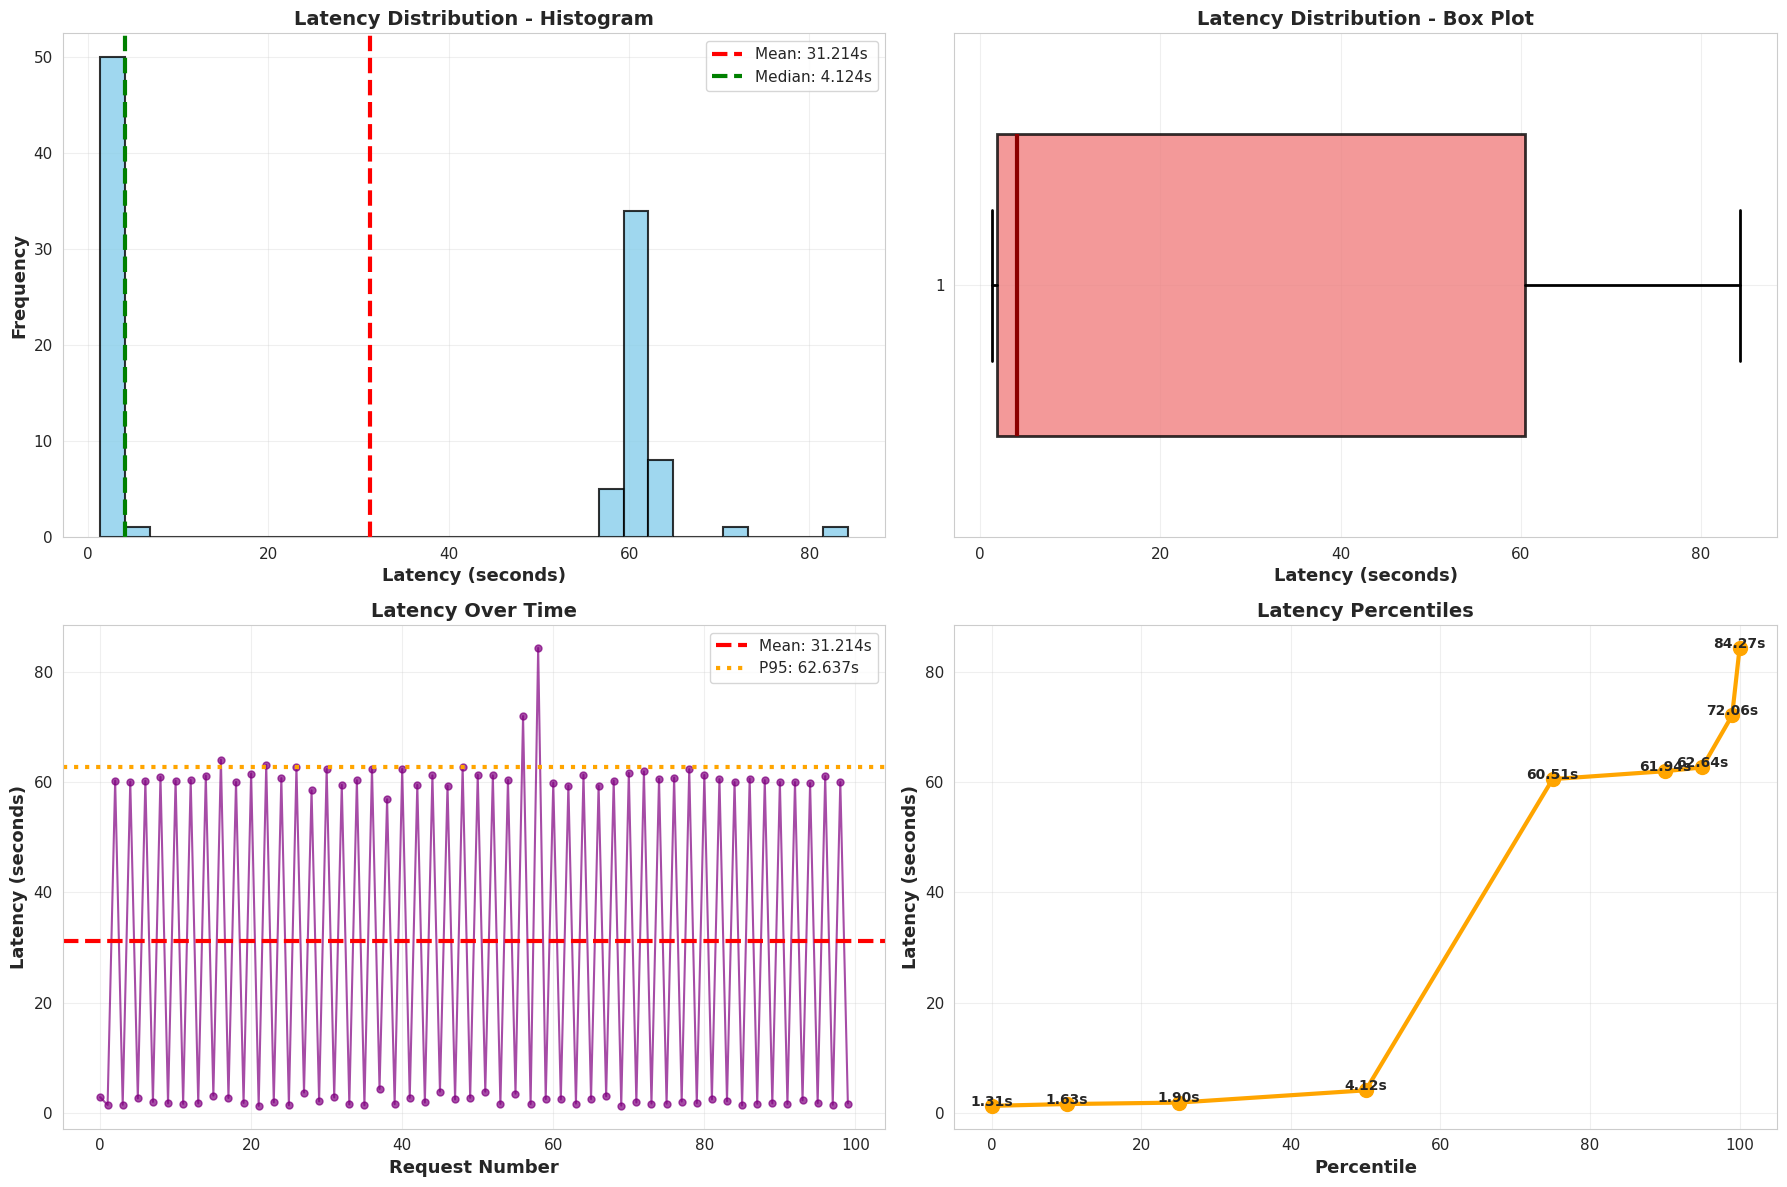

✓ Latency analysis complete


In [139]:
# Visualize latency distribution
latency_times = results["latency_times"]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Histogram
axes[0, 0].hist(latency_times, bins=30, color='skyblue', edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 0].axvline(latency_stats['mean'], color='red', linestyle='--', linewidth=3, 
                   label=f"Mean: {latency_stats['mean']:.3f}s")
axes[0, 0].axvline(latency_stats['median'], color='green', linestyle='--', linewidth=3, 
                   label=f"Median: {latency_stats['median']:.3f}s")
axes[0, 0].set_xlabel('Latency (seconds)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Latency Distribution - Histogram', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Box plot
bp = axes[0, 1].boxplot(latency_times, vert=False, patch_artist=True, widths=0.6,
                         boxprops=dict(facecolor='lightcoral', alpha=0.8, linewidth=2),
                         medianprops=dict(color='darkred', linewidth=3),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2))
axes[0, 1].set_xlabel('Latency (seconds)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Latency Distribution - Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Time series
axes[1, 0].plot(range(len(latency_times)), latency_times, marker='o', linestyle='-', 
                markersize=5, alpha=0.7, color='purple', linewidth=1.5)
axes[1, 0].axhline(latency_stats['mean'], color='red', linestyle='--', linewidth=3, 
                   label=f"Mean: {latency_stats['mean']:.3f}s")
axes[1, 0].axhline(latency_stats['p95'], color='orange', linestyle=':', linewidth=3, 
                   label=f"P95: {latency_stats['p95']:.3f}s")
axes[1, 0].set_xlabel('Request Number', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('Latency (seconds)', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Latency Over Time', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3)

# Percentile plot
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
percentile_values = [np.percentile(latency_times, p) for p in percentiles]
axes[1, 1].plot(percentiles, percentile_values, marker='o', linestyle='-', 
                markersize=10, linewidth=3, color='orange')
axes[1, 1].set_xlabel('Percentile', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('Latency (seconds)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Latency Percentiles', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
for p, v in zip(percentiles, percentile_values):
    axes[1, 1].text(p, v + 0.05, f'{v:.2f}s', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Latency analysis complete")

## Step 11: Error Analysis

In [140]:
# Display error analysis
if len(results["error_analysis"]) > 0:
    error_df = results["error_analysis"]
    
    print("=" * 85)
    print(f"ERROR ANALYSIS - {len(error_df)} Misclassifications Found")
    print("=" * 85)
    
    # Most common misclassification pairs
    error_pairs = error_df.groupby(['true_label', 'predicted_label']).size().sort_values(ascending=False)
    
    print(f"\n{'Most Common Misclassification Patterns':^85}")
    print("-" * 85)
    for (true_label, pred_label), count in error_pairs.head(10).items():
        percentage = (count / len(error_df)) * 100
        print(f"{true_label} → {pred_label}: {count} occurrences ({percentage:.1f}% of errors)")
    
    print(f"\n{'Sample Misclassifications':^85}")
    print("-" * 85)
    display_cols = ['image_path', 'true_label', 'predicted_label', 'latency']
    print(error_df[display_cols].head(20).to_string(index=False))
    
    print("=" * 85)
else:
    print("=" * 70)
    print("🎉 PERFECT CLASSIFICATION - NO ERRORS!")
    print("=" * 70)

ERROR ANALYSIS - 67 Misclassifications Found

                       Most Common Misclassification Patterns                        
-------------------------------------------------------------------------------------
1B → 1A: 13 occurrences (19.4% of errors)
2A → 2B: 13 occurrences (19.4% of errors)
1C → 1B: 7 occurrences (10.4% of errors)
1A → 1B: 6 occurrences (9.0% of errors)
2B → 2A: 6 occurrences (9.0% of errors)
1C → 2A: 4 occurrences (6.0% of errors)
2A → 1B: 4 occurrences (6.0% of errors)
1C → 1A: 3 occurrences (4.5% of errors)
1C → 2B: 2 occurrences (3.0% of errors)
1C → 4B: 2 occurrences (3.0% of errors)

                              Sample Misclassifications                              
-------------------------------------------------------------------------------------
             image_path true_label predicted_label   latency
data/Straight_1a_19.jpg         1A              1B  1.470450
data/Straight_1A_20.jpg         1A              1B 60.246569
data/Straight_1a_14.j

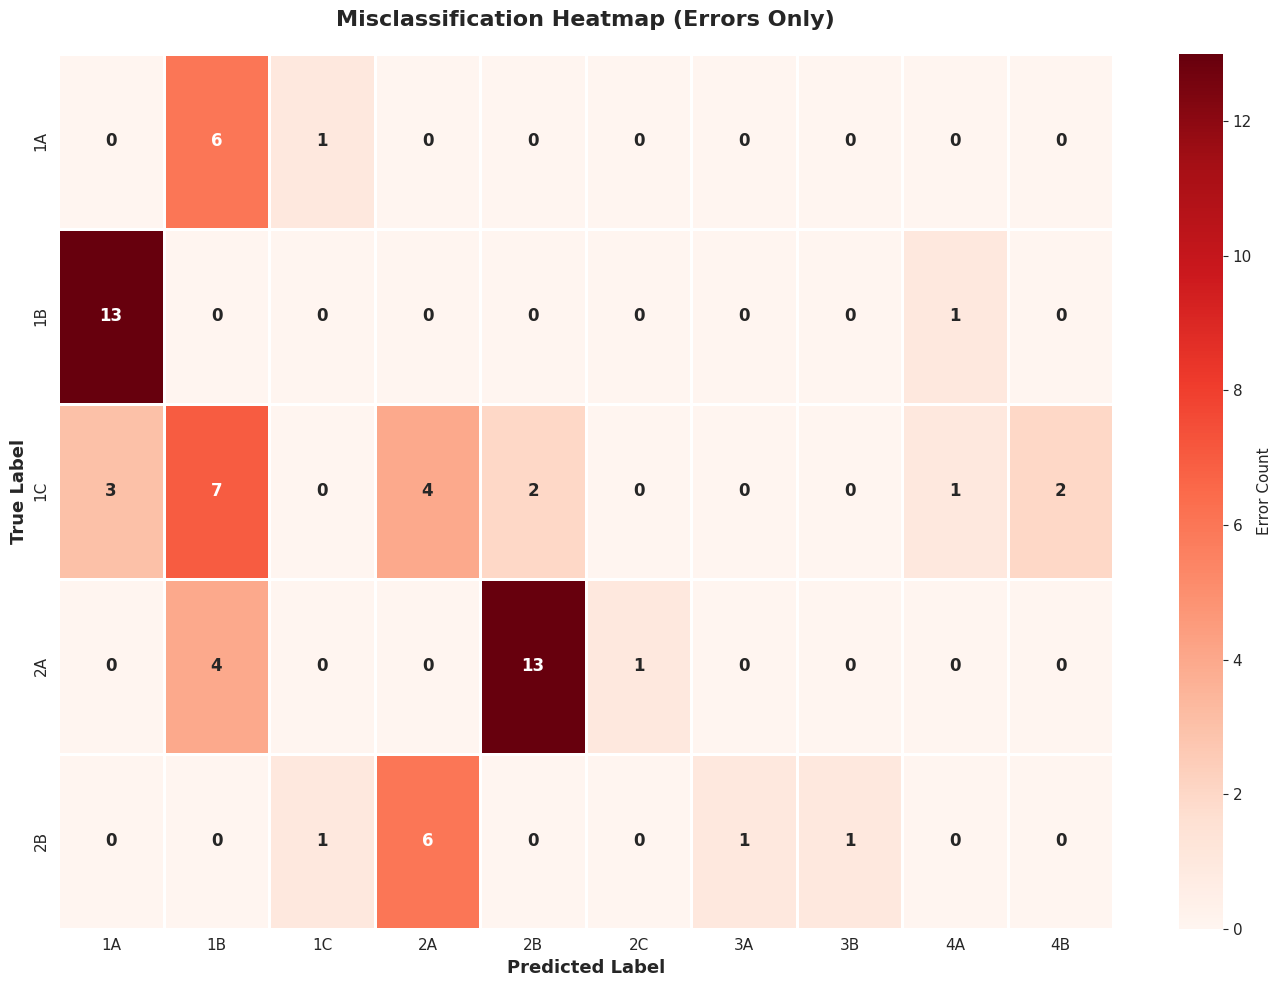

✓ Error analysis visualized

Interpretation:
- This heatmap shows only the misclassified samples
- Darker colors indicate more frequent confusion between classes
- Look for patterns: adjacent classes (e.g., 1A↔1B) often confused


In [141]:
# Visualize misclassification patterns
if len(results["error_analysis"]) > 0:
    error_df = results["error_analysis"]
    
    # Create error matrix
    error_pairs = error_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
    error_matrix = error_pairs.pivot(index='true_label', columns='predicted_label', values='count')
    error_matrix = error_matrix.fillna(0).astype(int)
    
    plt.figure(figsize=(14, 10))
    sns.heatmap(error_matrix, annot=True, fmt='d', cmap='Reds', linewidths=1, linecolor='white',
                annot_kws={'fontsize': 12, 'fontweight': 'bold'}, cbar_kws={'label': 'Error Count'})
    plt.title('Misclassification Heatmap (Errors Only)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
    plt.ylabel('True Label', fontsize=13, fontweight='bold')
    plt.tick_params(labelsize=11)
    plt.tight_layout()
    plt.show()
    
    print("✓ Error analysis visualized")
    print("\nInterpretation:")
    print("- This heatmap shows only the misclassified samples")
    print("- Darker colors indicate more frequent confusion between classes")
    print("- Look for patterns: adjacent classes (e.g., 1A↔1B) often confused")
else:
    print("✓ No errors to visualize - perfect classification!")

## Step 12: Comprehensive Summary Report

In [142]:
# Generate comprehensive summary report
print("\n" + "=" * 85)
print(" " * 30 + "PERFORMANCE SUMMARY REPORT")
print("=" * 85)

print(f"\n{'API Configuration':^85}")
print("-" * 85)
print(f"Provider:             {cfg.api['provider']}")
print(f"Model:                {cfg.api['model']}")
print(f"Temperature:          {cfg.api['temperature']}")
print(f"Timeout:              {cfg.api['timeout']}s")
print(f"Retries:              {cfg.api['retries']}")

print(f"\n{'Dataset Information':^85}")
print("-" * 85)
print(f"Original Dataset:     {len(df_full)} images")
print(f"Balanced Dataset:     {len(df_balanced)} images ({SAMPLES_PER_CLASS} per class)")
print(f"Number of Classes:    {len(labels)}")
print(f"Classes:              {', '.join(labels)}")

print(f"\n{'Classification Performance':^85}")
print("-" * 85)
print(f"Top-1 Accuracy (Exact):       {results['accuracy']*100:>6.2f}%")
print(f"Hierarchical Top-3 Accuracy:  {htop3_acc*100:>6.2f}%")
print(f"Neighbor Tolerance Benefit:   +{(htop3_acc - results['accuracy'])*100:>5.2f}pp")
print(f"Weighted F1-Score:            {results['weighted_f1']:>6.4f}")
print(f"Macro F1-Score:               {results['macro_f1']:>6.4f}")
print(f"Weighted Precision:           {results['weighted_precision']:>6.4f}")
print(f"Weighted Recall:              {results['weighted_recall']:>6.4f}")
print(f"Correct Predictions (Exact):  {results['n_samples'] - results['n_errors']:>6d} / {results['n_samples']}")
print(f"Neighbor Matches:             {neighbor_only:>6d}")
print(f"Cross-Family Errors:          {len(y_true) - len(neighbor_matches):>6d}")

print(f"\n{'Latency Performance':^85}")
print("-" * 85)
print(f"Mean Latency:                 {latency_stats['mean']:>10.3f}s")
print(f"Median Latency:               {latency_stats['median']:>10.3f}s")
print(f"P95 Latency:                  {latency_stats['p95']:>10.3f}s")
print(f"P99 Latency:                  {latency_stats['p99']:>10.3f}s")
print(f"Min Latency:                  {latency_stats['min']:>10.3f}s")
print(f"Max Latency:                  {latency_stats['max']:>10.3f}s")

print(f"\n{'Throughput (Sequential)':^85}")
print("-" * 85)
print(f"Requests/Second:              {throughput:>10.2f} req/s")
print(f"Requests/Minute:              {throughput * 60:>10.2f} req/min")
print(f"Time for 1000 images:         {(1000 / throughput) / 60:>10.2f} minutes")

print(f"\n{'Top 5 Best Performing Classes (by F1-Score)':^85}")
print("-" * 85)
best_classes = df_metrics.nlargest(5, 'F1-Score')[['Hair Type', 'F1-Score', 'Support']]
for idx, row in best_classes.iterrows():
    print(f"{row['Hair Type']}: F1={row['F1-Score']:.4f} (n={int(row['Support'])})")

print(f"\n{'Top 5 Worst Performing Classes (by F1-Score)':^85}")
print("-" * 85)
worst_classes = df_metrics.nsmallest(5, 'F1-Score')[['Hair Type', 'F1-Score', 'Support']]
for idx, row in worst_classes.iterrows():
    print(f"{row['Hair Type']}: F1={row['F1-Score']:.4f} (n={int(row['Support'])})")

print("\n" + "=" * 85)
print(" " * 25 + "✓ PERFORMANCE ANALYSIS COMPLETE")
print("=" * 85)

print("\n\nKey Findings:")
print(f"1. Top-1 accuracy (exact matches): {results['accuracy']*100:.2f}%")
print(f"2. Hierarchical top-3 accuracy: {htop3_acc*100:.2f}%")
print(f"3. {neighbor_only} predictions salvaged by neighbor tolerance")
print(f"4. Average response time: {latency_stats['mean']:.3f}s per image")
print(f"5. System can process ~{throughput * 60:.0f} images per minute")
print(f"6. Only {(1-htop3_acc)*100:.1f}% are critical cross-family errors")
print(f"7. Weighted F1-score: {results['weighted_f1']:.4f}")


                              PERFORMANCE SUMMARY REPORT

                                  API Configuration                                  
-------------------------------------------------------------------------------------
Provider:             azure_openai
Model:                gpt-4o-mini
Temperature:          0
Timeout:              30s
Retries:              2

                                 Dataset Information                                 
-------------------------------------------------------------------------------------
Original Dataset:     266 images
Balanced Dataset:     240 images (20 per class)
Number of Classes:    5
Classes:              1A, 1B, 1C, 2A, 2B

                             Classification Performance                              
-------------------------------------------------------------------------------------
Top-1 Accuracy (Exact):        33.00%
Hierarchical Top-3 Accuracy:   82.00%
Neighbor Tolerance Benefit:   +49.00pp
Weighted F1-Score: 

# Hair Classification Performance Analysis

This notebook provides comprehensive analysis of hair classification models for the performance report.

**Key Features:**
- Balanced dataset sampling (10 images per class)
- Complete evaluation metrics (accuracy, F1, precision, recall)
- Visualization of results (confusion matrix, latency distribution)
- Error analysis and misclassification patterns

---